# Import Packages

In [396]:
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

import pandas_datareader.data as web
import polars as pl
import wrds
from fredapi import Fred
from datetime import date

from functions.utils.func import *
from prep_factor import PrepFactor

# Params

In [397]:
start = '2005-01-01'
curr_date = date.today()
curr_date = curr_date + timedelta(days=1)
curr_date = curr_date.strftime('%Y-%m-%d')
save = False
live = True
stock = read_stock(get_large_dir(live) / 'permno_live.csv')

# Check for Irregular Price Data for Yfinance

In [409]:
ret = PrepFactor(live=live, factor_name='factor_ret', group='permno', interval='D', kind='price', stock=stock, div=False, start=start, end=curr_date, save=True).prep()

Creating factor_ret ---------------------------------------- | ✔
Shape: (3122923, 5)


In [353]:
price = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')

In [352]:
ret.loc[ret.RET_01 > 10]

,,RET_01,RET_05,RET_21,RET_126,RET_252
permno,date,,,,,
75383,2018-01-02,11.155555,11.155555,-0.745581,-0.769684,-0.791619


<AxesSubplot:xlabel='permno,date'>

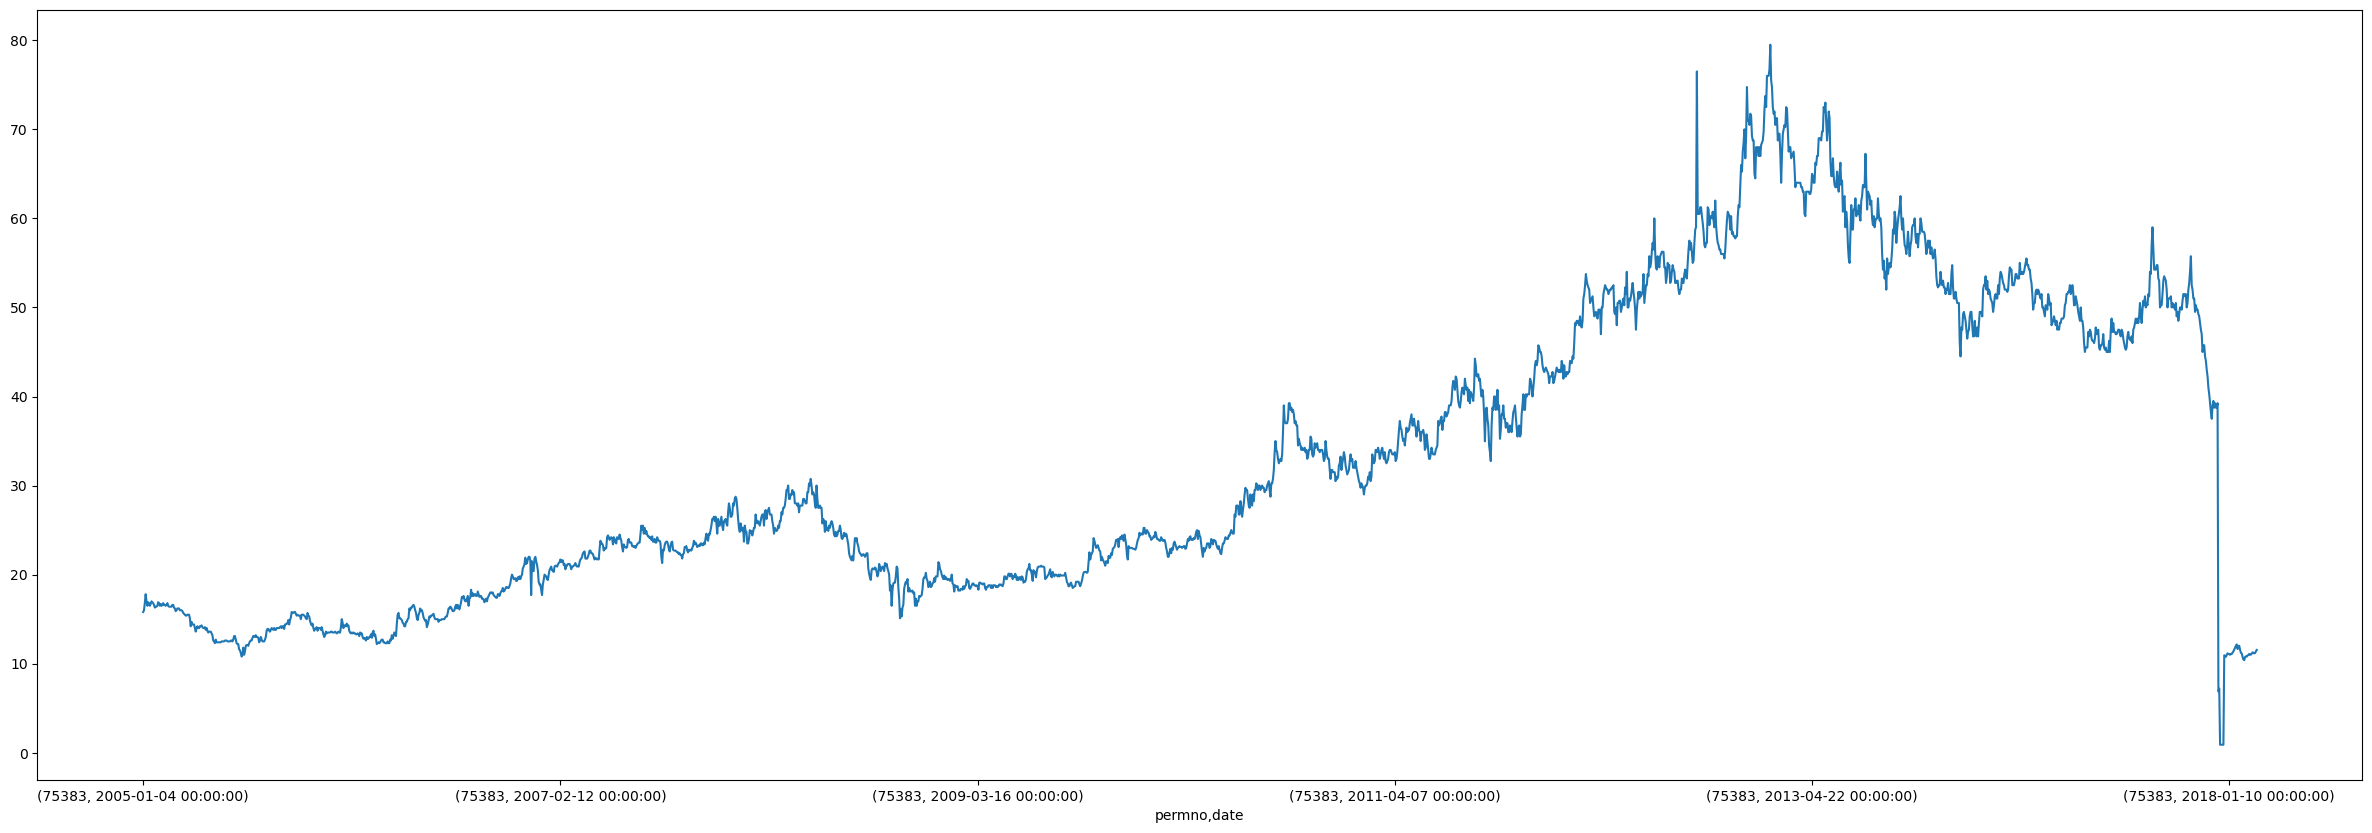

In [354]:
get_stock_data(price, 75383).Close.plot(figsize = (30, 10))

### Detect Irregularities

In [263]:
def detect_irregularities(df, window_size=60, z_threshold=7):
    # Calculate rolling mean and standard deviation
    df['rolling_mean'] = df.groupby(level='permno')['Close'].transform(lambda x: x.rolling(window=window_size).mean())
    df['rolling_std'] = df.groupby(level='permno')['Close'].transform(lambda x: x.rolling(window=window_size).std())
    
    # Compute the Z-score for each data point
    df['z_score'] = (df['Close'] - df['rolling_mean']) / df['rolling_std']
    
    # Detect irregularities based on Z-score threshold
    irregularities = df[df['z_score'].abs() > z_threshold]
    
    return irregularities

In [264]:
anomalies = detect_irregularities(price)

In [265]:
len(get_stock_idx(anomalies))

29

### Convert to ticker (Check with actual website)

In [356]:
ticker = pd.read_parquet(get_parquet_dir(live) / 'data_ticker.parquet.brotli')

In [358]:
get_stock_data(ticker, 75383).iloc[0][0]

'BEC'

# Adjust WFO (It predicts the remaining days now as well)

In [347]:
ret = PrepFactor(live=live, factor_name='factor_ret', group='permno', interval='D', kind='price', stock=stock, div=False, start=start, end=curr_date, save=save).prep()

Creating factor_ret ---------------------------------------- | ✔
Shape: (3090683, 5)


In [328]:
n_splits = (get_timeframe_length(ret) - 504) // 21

def wfo(data, n_splits, lookahead, train_period_length, test_period_length):
    unique_dates = data.index.get_level_values('date').unique()
    days = sorted(unique_dates)
    split_idx = []
    
    # Your existing loop to create split indices
    for i in range(n_splits):
        train_start_idx = i * test_period_length
        train_end_idx = train_start_idx + train_period_length - 1
        test_start_idx = train_end_idx + lookahead
        test_end_idx = test_start_idx + test_period_length - 1
        split_idx.append([train_start_idx, train_end_idx, test_start_idx, test_end_idx])
    
    # Check if the last test_end date is not the last available date
    if days[test_end_idx] < days[-1]:
        # Use the previous test_end as the start of the new training period
        train_start_idx = test_end_idx + 1 - train_period_length
        train_end_idx = test_end_idx
        
        # Set the testing window to start right after the previous one ended
        test_start_idx = test_end_idx + 1
        test_end_idx = len(days) - 1  # Last available date
        
        split_idx.append([train_start_idx, train_end_idx, test_start_idx, test_end_idx])
    
    dates = data.reset_index()[['date']]
    for train_start, train_end, test_start, test_end in split_idx:
        train_idx = dates[(days[train_start] <= dates.date) & (dates.date <= days[train_end])].index
        test_idx = dates[(days[test_start] <= dates.date) & (dates.date <= days[test_end])].index
        yield train_idx, test_idx

In [338]:
def _ewo(data, n_splits, lookahead, train_period_length, test_period_length):
    # Extract the unique dates in the dataframe
    unique_dates = data.index.get_level_values('date').unique()
    days = sorted(unique_dates)
    split_idx = []
    
    # Start training from the first available data point
    train_start_idx = 0
    
    # Creates the indices used to split the data for training and testing
    for i in range(n_splits):
        train_end_idx = train_start_idx + i * test_period_length + train_period_length - 1
        test_start_idx = train_end_idx + lookahead
        test_end_idx = test_start_idx + test_period_length - 1
        
        # If the last index exceeds the number of days (index out of bounds), break the loop
        if test_end_idx >= len(days):
            break
        
        split_idx.append([train_start_idx, train_end_idx, test_start_idx, test_end_idx])
    
    # Check if the last test_end date is not the last available date
    if days[test_end_idx] < days[-1]:
        test_start_idx = test_end_idx + 1
        test_end_idx = len(days) - 1  # Last available date
        train_end_idx = test_start_idx - lookahead  # Adjusting the training end index
        split_idx[-1] = [train_start_idx, train_end_idx, test_start_idx, test_end_idx]
    
    dates = data.reset_index()[['date']]
    for train_start, train_end, test_start, test_end in split_idx:
        train_idx = dates[(days[train_start] <= dates.date) & (dates.date <= days[train_end])].index
        test_idx = dates[(days[test_start] <= dates.date) & (dates.date <= days[test_end])].index
        yield train_idx, test_idx

In [339]:
walk = _ewo(ret, n_splits, 1, 504, 21)

for i in walk:
    continue

In [340]:
ret.iloc[i[1]]

RET_01    RET_05    RET_21   RET_126   RET_252
permno date                                                        
10104  2023-10-06  0.014859  0.038142 -0.120953  0.155212  0.677599
       2023-10-09  0.003274  0.033830 -0.126662  0.180750  0.717630
       2023-10-10 -0.005529  0.049656 -0.134165  0.171597  0.762380
       2023-10-11  0.003019  0.027654  0.003934  0.176010  0.788042
       2023-10-12 -0.004834  0.010699 -0.020840  0.150116  0.774837
...                     ...       ...       ...       ...       ...
93436  2023-10-16  0.011150 -0.022144 -0.074602  0.357571  0.145228
       2023-10-17  0.003663 -0.033268 -0.039317  0.382725  0.243231
       2023-10-18 -0.047754 -0.077227 -0.089381  0.343817  0.106360
       2023-10-19 -0.093003 -0.149728 -0.161773  0.350451 -0.000363
       2023-10-20 -0.036891 -0.155822 -0.170942  0.284165 -0.045262

[7515 rows x 5 columns]

In [341]:
ret.iloc[i[0]]

RET_01    RET_05    RET_21   RET_126   RET_252
permno date                                                        
10104  2013-01-02  0.041116  0.032133  0.084032  0.179290  0.363354
       2013-01-03 -0.010954  0.020827  0.067844  0.162458  0.356305
       2013-01-04  0.008744  0.040276  0.074852  0.165971  0.357054
       2013-01-07 -0.005201  0.042701  0.081959  0.169664  0.342210
       2013-01-08  0.000291  0.033614  0.081260  0.191656  0.313315
...                     ...       ...       ...       ...       ...
93436  2023-09-29  0.015586  0.021807 -0.026002  0.281340 -0.130607
       2023-10-02  0.005515  0.018665 -0.025108  0.212764 -0.061929
       2023-10-03 -0.020151  0.009872  0.006204  0.265749 -0.070575
       2023-10-04  0.059344  0.085904  0.018207  0.356112  0.077393
       2023-10-05 -0.004250  0.055483  0.032272  0.401736  0.042535

[1767867 rows x 5 columns]

# Dropping NANs

In [545]:
stock = read_stock(get_large_dir(live) / 'permno_live.csv')
data = PrepFactor(live=live, factor_name='factor_ret', group='permno', interval='D', kind='price', stock=stock, div=False, start=start, end=curr_date, save=False).prep()

Creating factor_ret ---------------------------------------- | ✔
Shape: (2313725, 5)


In [462]:
lookahead=1

In [479]:
# Remove the last row of data for each stock (due to shifting actual returns forward)
def filter_func(group):
    end_date = pd.Timestamp('2023-01-01')
    # Check if the date of the last row is not equal to self.end
    if abs(end_date - group.index[-1][1]).days >= 5:
        # Remove the last row
        return group.iloc[:-1]
    return group

In [480]:
data_change

RET_01    RET_05    RET_21   RET_126   RET_252  target_1D
permno date                                                                   
10104  2013-01-02  0.041116  0.032133  0.078166  0.168013  0.344574  -0.010954
       2013-01-03 -0.010954  0.020827  0.061900  0.151535  0.337622   0.008744
       2013-01-04  0.008744  0.040277  0.068870  0.154821  0.338102  -0.005201
       2013-01-07 -0.005201  0.042701  0.075937  0.158479  0.323722   0.000290
       2013-01-08  0.000290  0.033613  0.075242  0.180260  0.295224   0.000581
...                     ...       ...       ...       ...       ...        ...
93436  2022-12-23 -0.017551 -0.180257 -0.327784 -0.497183 -0.653749  -0.114089
       2022-12-27 -0.114089 -0.272036 -0.403369 -0.531082 -0.700806   0.033089
       2022-12-28  0.033089 -0.182075 -0.383829 -0.506718 -0.689353   0.080827
       2022-12-29  0.080827 -0.114487 -0.326329 -0.457307 -0.663540   0.011164
       2022-12-30  0.011164 -0.017312 -0.367334 -0.457986 -0.654745        NaN

[2170613 rows x 6 columns]

In [481]:
get_stock_data(data_change, 64629)

RET_01    RET_05    RET_21   RET_126   RET_252  target_1D
permno date                                                                   
64629  2013-01-02  0.019056  0.047575  0.066477  0.008079 -0.004433   0.013357
       2013-01-03  0.013357  0.058605  0.083810  0.020628 -0.011295   0.041301
       2013-01-04  0.041301  0.091160  0.126426  0.012821 -0.005872  -0.020253
       2013-01-07 -0.020253  0.083022  0.097353  0.013974 -0.017766  -0.013781
       2013-01-08 -0.013781  0.039020  0.094646  0.012378 -0.012079  -0.009607
...                     ...       ...       ...       ...       ...        ...
       2020-01-10 -0.056980  0.053412 -0.087404 -0.932316 -0.916175  -0.130704
       2020-01-13 -0.130704 -0.334268 -0.198442 -0.941664 -0.927644   0.131076
       2020-01-14  0.131076 -0.157495 -0.102353 -0.933387 -0.918920   0.117318
       2020-01-15  0.117318 -0.012658 -0.055004 -0.925287 -0.910755  -0.068974
       2020-01-16 -0.068974 -0.035463 -0.057984 -0.928874 -0.914965  -0.031672

[1773 rows x 6 columns]

# Compare Factors (Historical vs Live)

In [488]:
stock = read_stock(get_large_dir(live) / 'permno_live.csv')
factor_live = PrepFactor(live=live, factor_name='factor_chtax', group='permno', interval='D', kind='price', stock=stock, div=False, start=start, end=curr_date, save=False).prep()

Creating factor_chtax -------------------------------------- | ✔
Shape: (2170612, 1)


In [489]:
past_stock = read_stock(get_large_dir(False) / 'permno_to_train_fund.csv')
factor_historical = PrepFactor(live=False, factor_name='factor_chtax', group='permno', interval='D', kind='price', stock=past_stock, div=False, start=start, end=curr_date, save=False).prep()

Creating factor_chtax -------------------------------------- | ✔
Shape: (3479539, 1)


In [490]:
present = set_timeframe(factor_live, '2015-01-01', '2023-01-01')

In [491]:
past = set_timeframe(factor_historical, '2015-01-01', '2023-01-01')

In [494]:
len(get_stock_idx(present))

1016

In [496]:
len(get_stock_idx(past))

979

<AxesSubplot:xlabel='permno,date'>

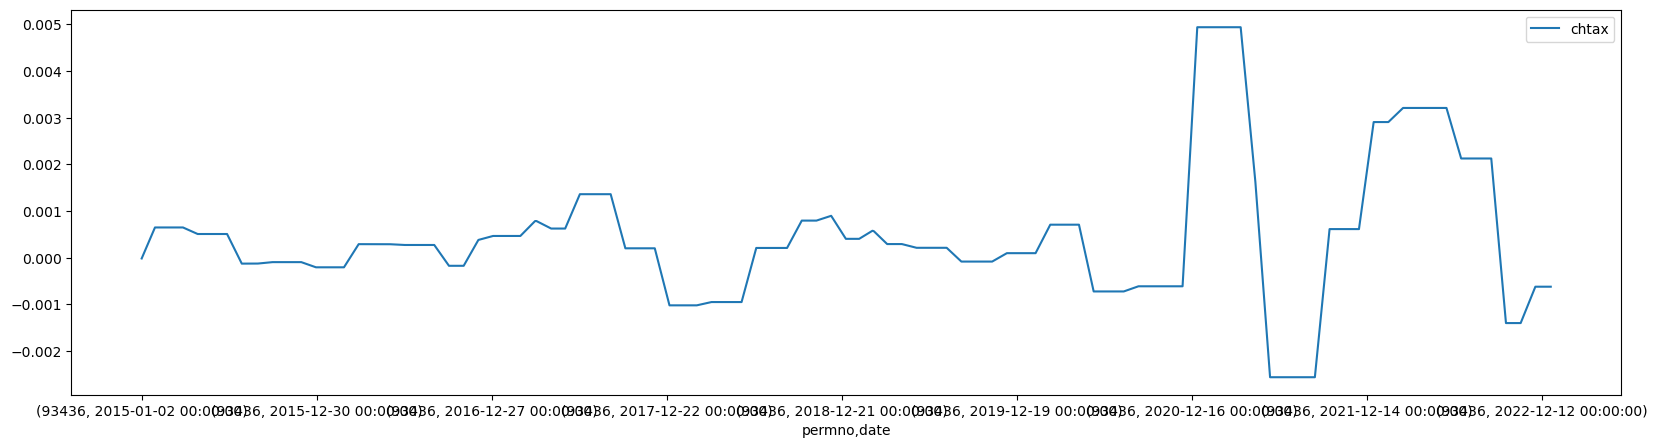

In [507]:
get_stock_data(present, 93436).plot(figsize=(20,5))

<AxesSubplot:xlabel='permno,date'>

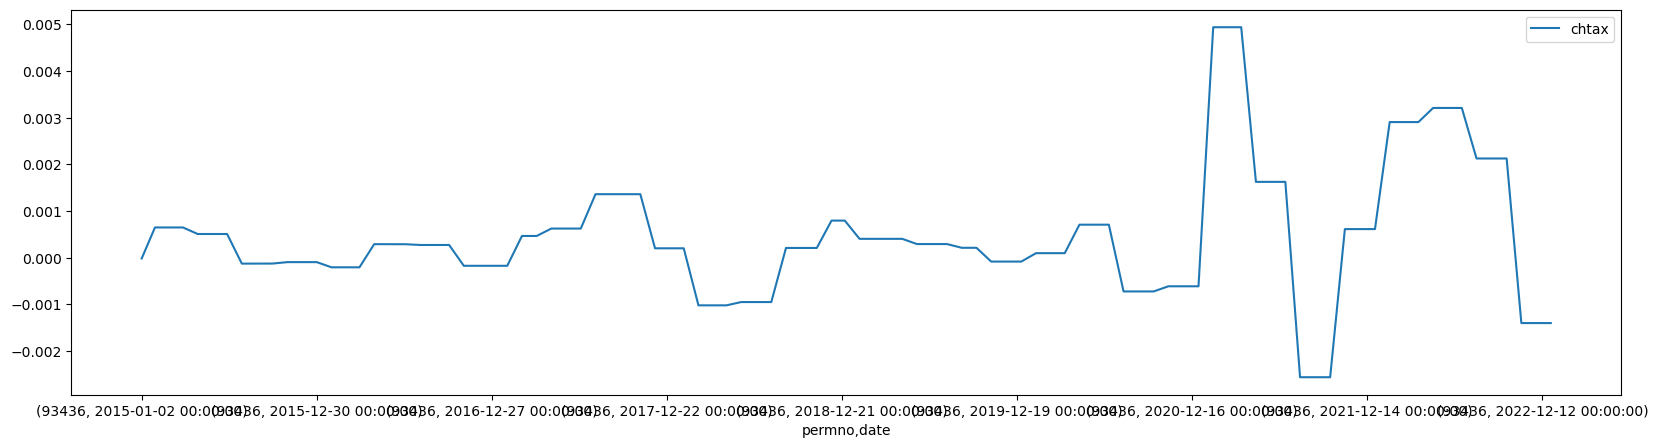

In [508]:
get_stock_data(past, 93436).plot(figsize=(20,5))

In [520]:
stock = read_stock(get_large_dir(live) / 'permno_live.csv')
factor_live = PrepFactor(live=live, factor_name='factor_ind_fama', group='permno', interval='D', kind='price', stock=stock, div=False, start=start, end=curr_date, save=False).prep()

Creating factor_ind_fama ----------------------------------- | ✔
Shape: (2170612, 1)


In [521]:
past_stock = read_stock(get_large_dir(False) / 'permno_to_train_fund.csv')
factor_historical = PrepFactor(live=False, factor_name='factor_ind_fama', group='permno', interval='D', kind='price', stock=past_stock, div=False, start=start, end=curr_date, save=False).prep()

Creating factor_ind_fama ----------------------------------- | ✔
Shape: (3479539, 1)


In [522]:
present = set_timeframe(factor_live, '2015-01-01', '2023-01-01')

In [523]:
past = set_timeframe(factor_historical, '2015-01-01', '2023-01-01')

In [524]:
len(get_stock_idx(present))

1016

In [525]:
len(get_stock_idx(past))

979

In [526]:
present.head(5)

IndustryFama
permno date                    
10104  2015-01-02            27
       2015-01-05            27
       2015-01-06            27
       2015-01-07            27
       2015-01-08            27

In [527]:
past.head(5)

IndustryFama
permno date                    
10104  2015-01-02             1
       2015-01-05             1
       2015-01-06             1
       2015-01-07             1
       2015-01-08             1

<AxesSubplot:xlabel='permno,date'>

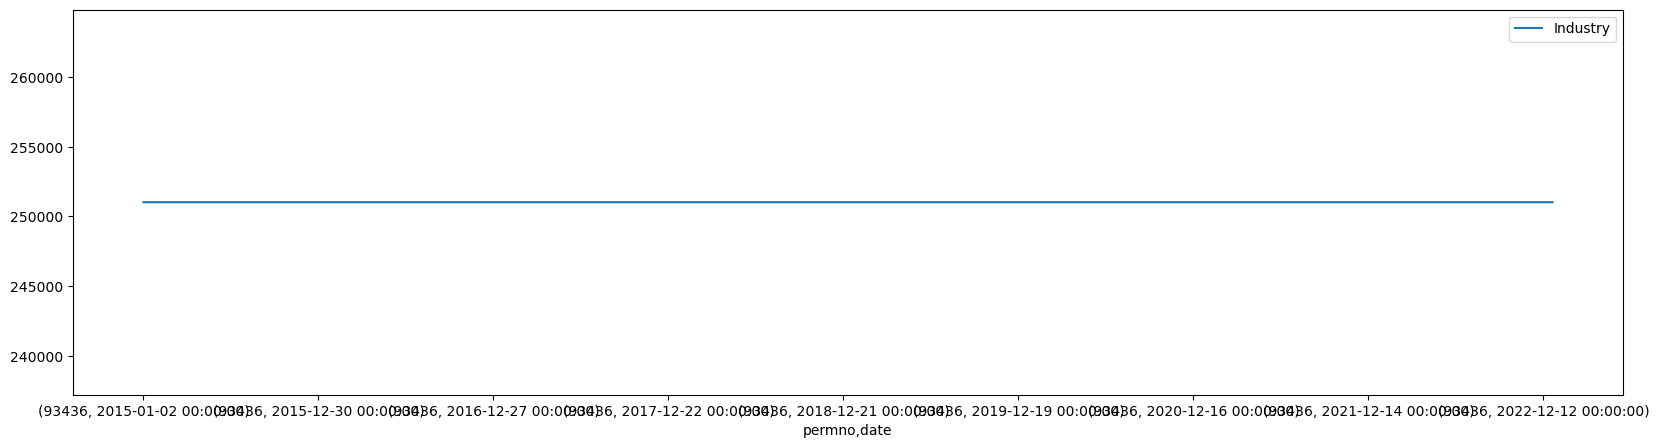

In [515]:
get_stock_data(present, 93436).plot(figsize=(20,5))

<AxesSubplot:xlabel='permno,date'>

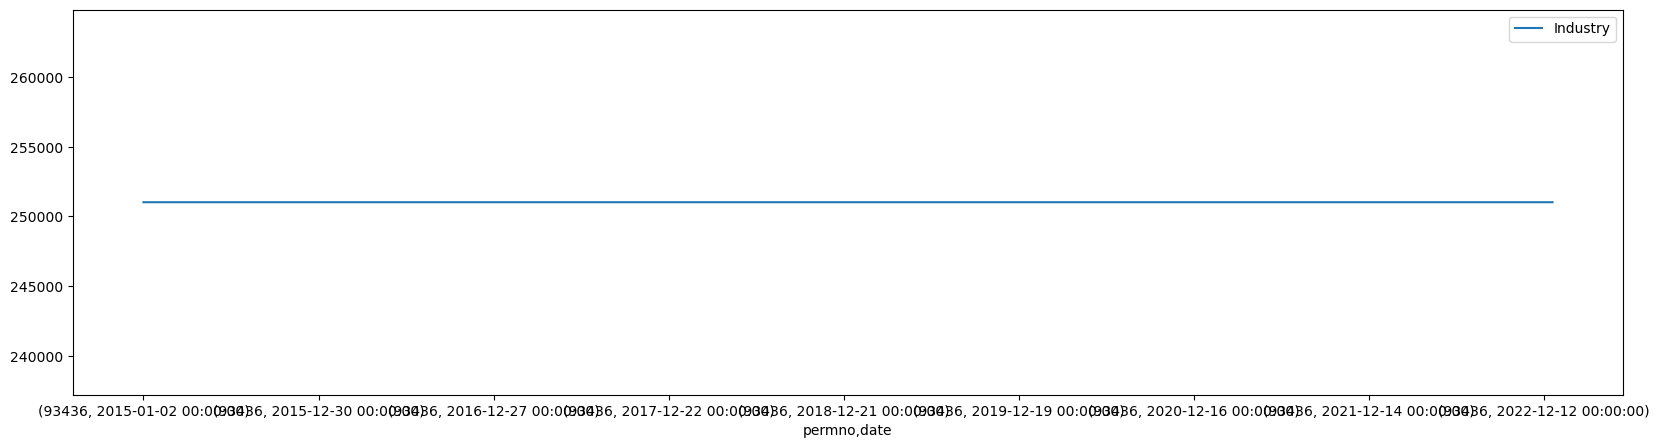

In [516]:
get_stock_data(past, 93436).plot(figsize=(20,5))

# Check Industry

In [528]:
db = wrds.Connection(wrds_username='jofan23')

Loading library list...
Done


In [529]:
db.close()

In [531]:
past_stock = read_stock(get_large_dir(False) / 'permno_to_train_fund.csv')

In [540]:
len(past_stock)

1054

In [533]:
fund_q = pd.read_parquet(get_parquet_dir(True) / 'data_fund_raw_q.parquet.brotli')

In [536]:
len(get_stock_idx(get_stocks_data(fund_q, past_stock)))

1014

In [537]:
len(past_stock)

1054

In [542]:
price_now = pd.read_parquet(get_parquet_dir(True) / 'data_crsp_price.parquet.brotli')

In [543]:
len(get_stock_idx(get_stocks_data(price_now, past_stock)))

842

In [546]:
crsp = pd.read_parquet(get_parquet_dir(False) / 'data_misc.parquet.brotli')

In [548]:
crsp.shape

(4127732, 35)

In [549]:
# Drop permnos that have the same ticker on the last date of the dataframe
print('Export ticker and filter out any permnos that share tickers on the last date...')
last_date = crsp.index.get_level_values('date').max()
filtered_df = crsp[crsp.index.get_level_values('date') == last_date]
duplicated_tickers = filtered_df[filtered_df['ticker'].duplicated(keep=False)]['ticker'].unique()
permnos_to_drop = filtered_df[filtered_df['ticker'].isin(duplicated_tickers)].index.get_level_values('permno').unique()
remove_ticker = crsp[~crsp.index.get_level_values('permno').isin(permnos_to_drop)]

Export ticker and filter out any permnos that share tickers on the last date...


In [550]:
remove_ticker.shape

(4118670, 35)

In [551]:
x = pd.read_parquet(get_factor_dir(True) / 'factor_ret.parquet.brotli')

In [562]:
x.loc[x.RET_01 > 6]

,,Open,High,Low,Close,Volume,RET_01,RET_05,RET_21,RET_126,RET_252
permno,date,,,,,,,,,,
13883,2023-10-11,2.13,9.77,1.82,9.770000,173029900.0,39.708336,32.231294,16.140352,1.598404,4.815476
92345,2019-06-10,1.10,3.07,3.10,108.501628,53100580.0,8.748428,9.048622,4.438596,1.480000,0.409091


In [556]:
ticker = pd.read_parquet(get_parquet_dir(True) / 'data_ticker.parquet.brotli')

In [558]:
get_stock_data(ticker, 13883)

ticker
permno date             
13883  2013-04-30   OVAS
       2013-05-01   OVAS
       2013-05-02   OVAS
       2013-05-03   OVAS
       2013-05-06   OVAS
...                  ...
       2023-10-17   TPST
       2023-10-18   TPST
       2023-10-19   TPST
       2023-10-20   TPST
       2023-10-23   TPST

[2640 rows x 1 columns]